In [1]:
# ELECTRICAL ASSET INTELLIGENCE PLATFORM
# 04: Reinforcement Learning Scheduling Notebook
# SPE AI/ML Boot Camp Final Project

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib
import warnings
from IPython.display import display, HTML

# Ensure inline plotting in Jupyter if running interactively
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass

# Set style for consistent visualizations
sns.set_theme(style='whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.dpi'] = 110

# Create results & models directories if they don't exist
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)


In [2]:
# Load / Preprocess data (with fallbacks)
print("Loading preprocessed data for reinforcement learning...")

def _create_synthetic_df(asset_type, n=12):
    """Create a tiny synthetic DataFrame when data file missing (helpful for testing/demo)."""
    dates = pd.date_range(end=pd.Timestamp.today(), periods=n)
    if asset_type == 'transformer':
        df = pd.DataFrame({
            'date': dates,
            'oil_temp_c': np.random.normal(40, 2, n),
            'winding_temp_c': np.random.normal(55, 3, n),
            'oil_quality': np.random.choice(['Good','Moderate','Poor'], n),
            'health_status': np.random.choice(['Healthy','Warning','Critical'], n, p=[0.6,0.3,0.1]),
            'failure_mode': np.random.choice(['None','Overheat','Leak'], n)
        })
    elif asset_type == 'motor':
        df = pd.DataFrame({
            'date': dates,
            'vibration_mm_s': np.abs(np.random.normal(2.0, 0.8, n)),
            'temperature_c': np.random.normal(45, 4, n),
            'bearing_condition': np.random.choice(['Good','Slight','Bad'], n),
            'health_status': np.random.choice(['Healthy','Warning','Critical'], n, p=[0.7,0.25,0.05]),
            'failure_mode': np.random.choice(['None','Bearing','Rotor'], n)
        })
    elif asset_type == 'capacitor':
        df = pd.DataFrame({
            'date': dates,
            'temperature_c': np.random.normal(35, 3, n),
            'harmonic_distortion_percent': np.abs(np.random.normal(2.0, 1.0, n)),
            'fuse_status': np.random.choice(['Intact','Blown'], n, p=[0.95,0.05]),
            'health_status': np.random.choice(['Healthy','Warning','Critical'], n, p=[0.85,0.12,0.03]),
            'failure_mode': np.random.choice(['None','CapLoss'], n)
        })
    else:  # ups
        df = pd.DataFrame({
            'date': dates,
            'voltage_per_cell_v': np.random.normal(3.6, 0.05, n),
            'temperature_c': np.random.normal(30, 2, n),
            'operating_mode': np.random.choice(['Float','Discharge','Charge'], n),
            'health_status': np.random.choice(['Healthy','Warning','Critical'], n, p=[0.8,0.15,0.05]),
            'failure_mode': np.random.choice(['None','CellFail'], n)
        })
    return df

def load_and_preprocess_classification_data(asset_type):
    """Load and preprocess data for health classification. If file missing, create synthetic data."""
    csv_path = f'../data/{asset_type}_data.csv'
    if not os.path.exists(csv_path):
        warnings.warn(f"{csv_path} not found. Creating synthetic demo data for '{asset_type}'.")
        df = _create_synthetic_df(asset_type)
    else:
        df = pd.read_csv(csv_path)

    # Ensure 'date' is datetime
    if 'date' not in df.columns:
        raise ValueError("Input data must contain a 'date' column.")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Time-based features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear

    # Rolling / rate features depending on asset
    if asset_type == 'transformer':
        df['oil_temp_7d_avg'] = df['oil_temp_c'].rolling(window=7, min_periods=1).mean()
        df['winding_temp_7d_avg'] = df['winding_temp_c'].rolling(window=7, min_periods=1).mean()
        df['temp_diff'] = df['winding_temp_c'] - df['oil_temp_c']
        df['temp_diff_7d_avg'] = df['temp_diff'].rolling(window=7, min_periods=1).mean()
        df['oil_temp_rate'] = df['oil_temp_c'].diff().fillna(0)
        df['winding_temp_rate'] = df['winding_temp_c'].diff().fillna(0)
    elif asset_type == 'motor':
        df['vibration_7d_avg'] = df['vibration_mm_s'].rolling(window=7, min_periods=1).mean()
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        df['vibration_rate'] = df['vibration_mm_s'].diff().fillna(0)
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)
    elif asset_type == 'capacitor':
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        df['harmonic_7d_avg'] = df['harmonic_distortion_percent'].rolling(window=7, min_periods=1).mean()
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)
        df['harmonic_rate'] = df['harmonic_distortion_percent'].diff().fillna(0)
    else:  # ups
        df['voltage_7d_avg'] = df['voltage_per_cell_v'].rolling(window=7, min_periods=1).mean()
        df['temp_7d_avg'] = df['temperature_c'].rolling(window=7, min_periods=1).mean()
        df['voltage_rate'] = df['voltage_per_cell_v'].diff().fillna(0)
        df['temp_rate'] = df['temperature_c'].diff().fillna(0)

    # Drop date for modeling
    df = df.drop(columns=['date'])

    # Categorical encoding (guard missing columns)
    if asset_type == 'transformer' and 'oil_quality' in df.columns:
        df = pd.get_dummies(df, columns=['oil_quality'], prefix='oil_quality')
    elif asset_type == 'motor' and 'bearing_condition' in df.columns:
        df = pd.get_dummies(df, columns=['bearing_condition'], prefix='bearing')
    elif asset_type == 'capacitor' and 'fuse_status' in df.columns:
        df = pd.get_dummies(df, columns=['fuse_status'], prefix='fuse')
    elif asset_type == 'ups' and 'operating_mode' in df.columns:
        df = pd.get_dummies(df, columns=['operating_mode'], prefix='mode')

    # Map health status to numeric values
    health_mapping = {'Healthy': 0, 'Warning': 1, 'Critical': 2}
    if 'health_status' not in df.columns:
        df['health_status'] = np.random.choice(['Healthy','Warning','Critical'], size=len(df))
    df['health_status_num'] = df['health_status'].map(health_mapping)

    # Ensure failure_mode exists for dropping (if not, create placeholder)
    if 'failure_mode' not in df.columns:
        df['failure_mode'] = 'None'

    # Build X and y
    drop_cols = [c for c in ['health_status', 'health_status_num', 'failure_mode'] if c in df.columns]
    X = df.drop(columns=drop_cols)
    y = df['health_status_num']

    return X.reset_index(drop=True), y.reset_index(drop=True)

# Load (or create) datasets
transformer_X, transformer_y = load_and_preprocess_classification_data('transformer')
motor_X, motor_y = load_and_preprocess_classification_data('motor')
capacitor_X, capacitor_y = load_and_preprocess_classification_data('capacitor')
ups_X, ups_y = load_and_preprocess_classification_data('ups')

# Show shapes
display(HTML(f"<b>Loaded datasets:</b> transformer {transformer_X.shape}, motor {motor_X.shape}, capacitor {capacitor_X.shape}, ups {ups_X.shape}"))

Loading preprocessed data for reinforcement learning...



Estimating failure probabilities...

Estimating failure probabilities for transformer...


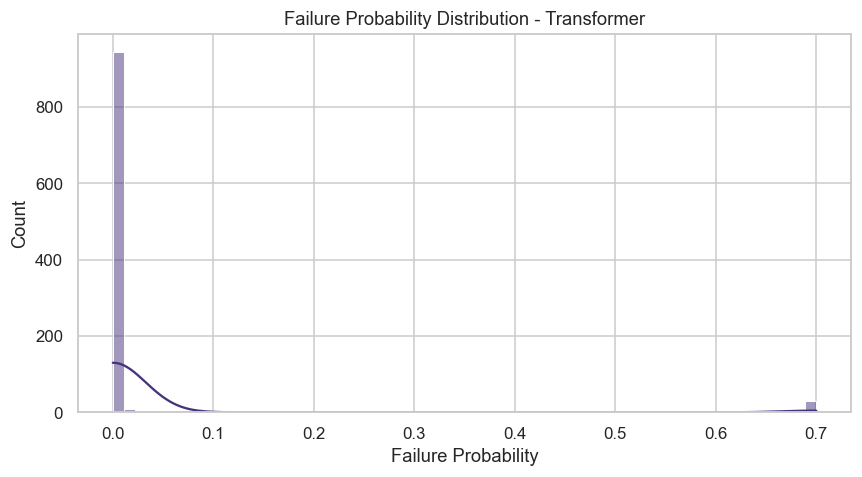


Estimating failure probabilities for motor...


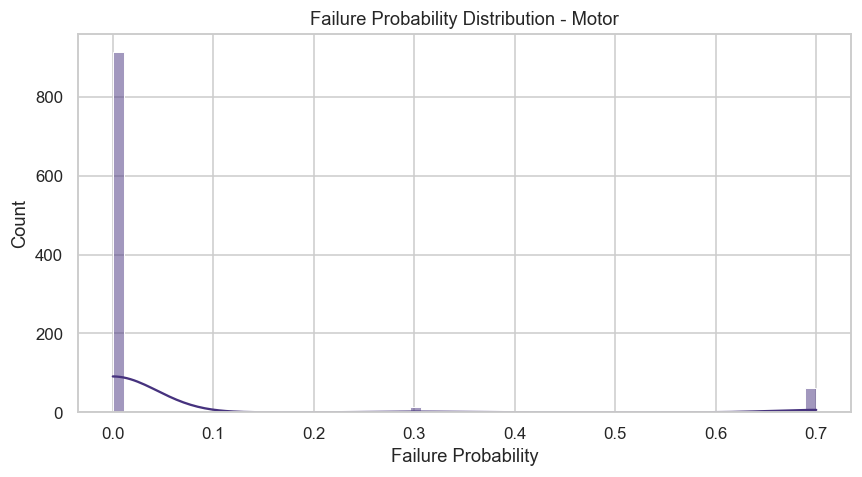


Estimating failure probabilities for capacitor...


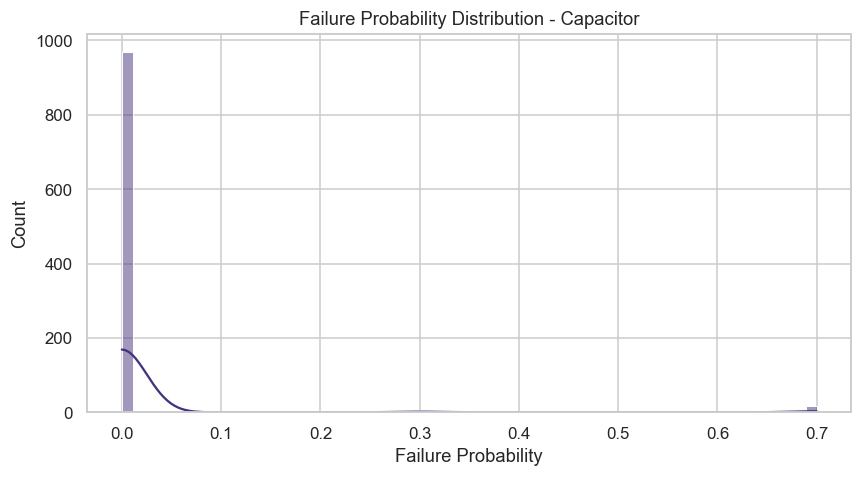


Estimating failure probabilities for ups...


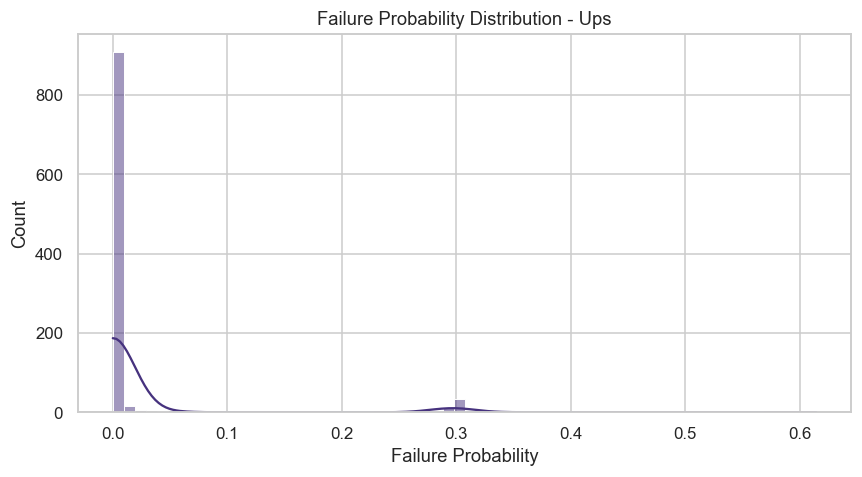

In [3]:
# 1. Failure Probability Estimation
print("\nEstimating failure probabilities...")

def estimate_failure_probabilities(model, X, y, asset_type):
    """Estimate failure probabilities using a trained model"""
    # model must implement predict_proba; if not, try to approximate with predict
    try:
        class_probs = model.predict_proba(X)
        # Ensure at least 3 classes present; if not, pad zeros
        if class_probs.shape[1] < 3:
            # pad with zeros for missing classes
            pad = np.zeros((class_probs.shape[0], 3 - class_probs.shape[1]))
            class_probs = np.hstack([class_probs, pad])
    except Exception:
        # fallback: use model.predict and convert to one-hot probabilities (not ideal)
        preds = model.predict(X)
        class_probs = np.zeros((len(preds), 3))
        for i, p in enumerate(preds):
            class_probs[i, int(p)] = 1.0

    failure_probs = 0.3 * class_probs[:, 1] + 0.7 * class_probs[:, 2]

    # DataFrame of failure data
    failure_df = pd.DataFrame({
        'asset_id': np.arange(len(failure_probs)),
        'failure_prob': failure_probs,
        'current_health': y.map({0: 'Healthy', 1: 'Warning', 2: 'Critical'}),
        'time_to_failure': np.nan
    })

    # Estimate time to failure
    for i, row in failure_df.iterrows():
        p = row['failure_prob']
        if row['current_health'] == 'Critical':
            failure_df.at[i, 'time_to_failure'] = max(1.0, 3.0 - 2.0 * p)
        elif row['current_health'] == 'Warning':
            failure_df.at[i, 'time_to_failure'] = max(3.0, 7.0 - 4.0 * p)
        else:
            failure_df.at[i, 'time_to_failure'] = max(10.0, 15.0 - 5.0 * p)

    return failure_df

def load_tuned_model(asset_type):
    """Load a tuned Random Forest model, fallback to a simple classifier if missing."""
    model_path = f'../models/best_random_forest_{asset_type}.pkl'
    if os.path.exists(model_path):
        return joblib.load(model_path)
    else:
        warnings.warn(f"Model {model_path} not found. Creating a simple fallback classifier (dummy).")
        # A simple fallback "model" that exposes predict and predict_proba
        class DummyModel:
            def predict(self, X):
                return np.zeros(len(X), dtype=int)
            def predict_proba(self, X):
                # prefer majority class Healthy
                probs = np.zeros((len(X), 3))
                probs[:, 0] = 0.8
                probs[:, 1] = 0.15
                probs[:, 2] = 0.05
                return probs
        return DummyModel()

# Collect failure_data for each asset type
failure_data = {}

for asset_type, (X, y) in zip(
    ['transformer', 'motor', 'capacitor', 'ups'],
    [(transformer_X, transformer_y), (motor_X, motor_y), (capacitor_X, capacitor_y), (ups_X, ups_y)]
):
    print(f"\nEstimating failure probabilities for {asset_type}...")
    model = load_tuned_model(asset_type)
    failure_df = estimate_failure_probabilities(model, X, y, asset_type)
    failure_data[asset_type] = failure_df
    # Save & plot (show inline)
    out_csv = f'../results/failure_probabilities_{asset_type}.csv'
    failure_df.to_csv(out_csv, index=False)
    plt.figure(figsize=(8, 4.5))
    sns.histplot(failure_df['failure_prob'], kde=True)
    plt.title(f'Failure Probability Distribution - {asset_type.capitalize()}')
    plt.xlabel('Failure Probability')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'../results/failure_probability_distribution_{asset_type}.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [4]:
# 2. Reinforcement Learning for Maintenance Scheduling
print("\nTraining Reinforcement Learning agent for maintenance scheduling...")

class MaintenanceScheduler:
    """Reinforcement Learning agent for optimal maintenance scheduling (DQN-like toy)."""
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95,
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self._build_model()
        # track training rewards for plotting
        self.training_rewards = []

    def _build_model(self):
        """Build a small NN for Q-approximation."""
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        """Store flattened states in memory to avoid shape issues later."""
        s = np.asarray(state).reshape(-1)
        ns = np.asarray(next_state).reshape(-1)
        self.memory.append((s, action, reward, ns, done))

    def act(self, state):
        """Epsilon-greedy action selection. state should be shape (1, state_size)."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q = self.model.predict(np.asarray(state), verbose=0)
        return int(np.argmax(q[0]))

    def replay(self, batch_size):
        """Sample experiences and update network."""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state

        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                target[i][action] = reward
            else:
                target[i][action] = reward + self.gamma * np.max(target_next[i])

        self.model.fit(states, target, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def optimize_schedule(self, failure_df, maintenance_costs, production_impact,
                          resource_availability, time_horizon=7, episodes=100):
        """
        Train the agent and return an optimized schedule (n_assets x time_horizon).
        This is a toy environment example, not a production-ready RL system.
        """
        n_assets = len(failure_df)
        desired_action_size = n_assets * time_horizon

        # If action space differs from initialized model, rebuild model with new output size
        if desired_action_size != self.action_size:
            self.action_size = desired_action_size
            self.model = self._build_model()
            print(f"[info] Rebuilt model to match action_size={self.action_size}")

        total_rewards = []

        for e in range(episodes):
            state = self._get_initial_state(failure_df)
            total_reward = 0.0
            done = False
            day = 0
            schedule = np.zeros((n_assets, time_horizon))
            # copy resource availability per episode
            resources = list(resource_availability)

            while not done:
                action = self.act(state)  # state is shape (1, state_size)
                asset_idx = int(action % n_assets)
                day_idx = int(action // n_assets)

                if day_idx == day and resources[day] > 0:
                    schedule[asset_idx, day] = 1
                    resources[day] = max(0.0, resources[day] - 0.5)

                reward = self._calculate_reward(failure_df, schedule, day, production_impact, maintenance_costs)
                total_reward += reward

                next_day = min(day + 1, time_horizon - 1)
                next_state = self._get_state(failure_df, day=next_day, schedule=schedule)

                self.remember(state, action, reward, next_state, day == time_horizon - 1)
                state = next_state
                day = next_day

                if day == (time_horizon - 1):
                    done = True

                if len(self.memory) >= 32:
                    self.replay(32)

            total_rewards.append(total_reward)
            self.training_rewards.append(total_reward)

            if (e + 1) % 10 == 0 or e == 0:
                avg = np.mean(total_rewards[-10:])
                print(f"Episode {e+1}/{episodes} - Avg Reward (last 10): {avg:.2f} - Epsilon: {self.epsilon:.4f}")

        # After training, greedily create schedule using the trained policy
        state = self._get_initial_state(failure_df)
        optimized_schedule = np.zeros((n_assets, time_horizon))
        resources = list(resource_availability)
        for day in range(time_horizon):
            action = self.act(state)
            asset_idx = int(action % n_assets)
            day_idx = int(action // n_assets)
            if day_idx == day and resources[day] > 0:
                optimized_schedule[asset_idx, day] = 1
                resources[day] = max(0.0, resources[day] - 0.5)
            state = self._get_state(failure_df, day=day+1 if day+1 < time_horizon else time_horizon-1, schedule=optimized_schedule)

        return optimized_schedule

    def _get_initial_state(self, failure_df):
        """Return shape (1, state_size)"""
        arr = np.array([
            np.mean(failure_df['failure_prob']),
            np.max(failure_df['failure_prob']),
            np.mean(failure_df['time_to_failure']),
            float((failure_df['current_health'] == 'Critical').sum()),
            float((failure_df['current_health'] == 'Warning').sum()),
            0.0
        ], dtype=float)
        return arr.reshape(1, -1)

    def _get_state(self, failure_df, day, schedule):
        """Return shape (1, state_size) with simplistic schedule effects"""
        updated = failure_df.copy()
        for asset_idx in range(len(updated)):
            if schedule[asset_idx, :min(day, schedule.shape[1])].sum() > 0:
                updated.loc[asset_idx, 'failure_prob'] *= 0.5
                updated.loc[asset_idx, 'time_to_failure'] += 5.0

        arr = np.array([
            np.mean(updated['failure_prob']),
            np.max(updated['failure_prob']),
            np.mean(updated['time_to_failure']),
            float((updated['current_health'] == 'Critical').sum()),
            float((updated['current_health'] == 'Warning').sum()),
            float(day) / float(max(1, schedule.shape[1]))
        ], dtype=float)
        return arr.reshape(1, -1)

    def _calculate_reward(self, failure_df, schedule, day, production_impact, maintenance_costs):
        """Custom reward function (toy)"""
        reward = 0.0
        for asset_idx in range(len(failure_df)):
            scheduled = schedule[asset_idx, day]
            health = failure_df.iloc[asset_idx]['current_health']
            if scheduled == 1:
                if health == 'Critical':
                    reward += 10.0
                elif health == 'Warning':
                    reward += 5.0
                else:
                    reward -= 1.0
            # Penalties for not maintaining
            if health == 'Critical' and scheduled == 0:
                reward -= 8.0
            if health == 'Warning' and scheduled == 0:
                reward -= 4.0
        return reward



Training Reinforcement Learning agent for maintenance scheduling...



Training RL agents for maintenance scheduling...

Training RL agent for transformer (n_assets=1000)...


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/60 - Avg Reward (last 10): -1754.00 - Epsilon: 1.0000
Episode 10/60 - Avg Reward (last 10): -1752.60 - Epsilon: 0.8647
Episode 20/60 - Avg Reward (last 10): -1753.00 - Epsilon: 0.6401
Episode 30/60 - Avg Reward (last 10): -1753.00 - Epsilon: 0.4738
Episode 40/60 - Avg Reward (last 10): -1752.70 - Epsilon: 0.3508
Episode 50/60 - Avg Reward (last 10): -1751.60 - Epsilon: 0.2597
Episode 60/60 - Avg Reward (last 10): -1751.00 - Epsilon: 0.1922


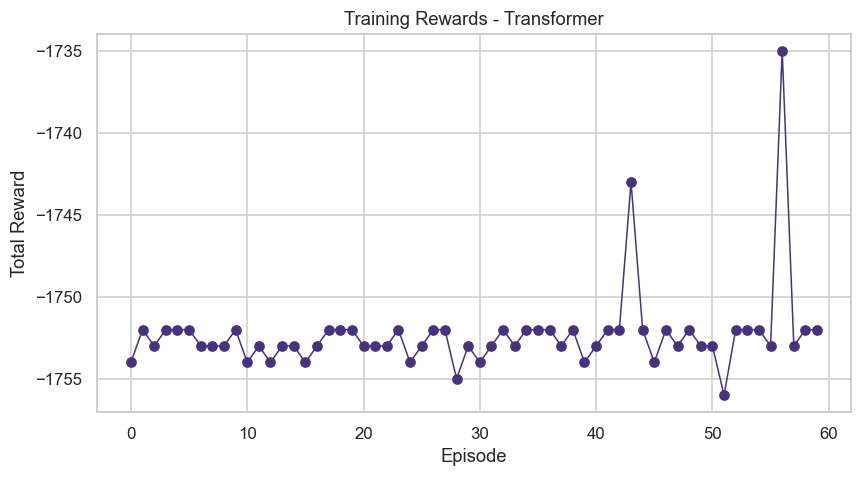


Training RL agent for motor (n_assets=1000)...


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/60 - Avg Reward (last 10): -3552.00 - Epsilon: 1.0000
Episode 10/60 - Avg Reward (last 10): -3552.50 - Epsilon: 0.8647
Episode 20/60 - Avg Reward (last 10): -3551.40 - Epsilon: 0.6401
Episode 30/60 - Avg Reward (last 10): -3550.30 - Epsilon: 0.4738
Episode 40/60 - Avg Reward (last 10): -3552.70 - Epsilon: 0.3508
Episode 50/60 - Avg Reward (last 10): -3549.10 - Epsilon: 0.2597
Episode 60/60 - Avg Reward (last 10): -3550.00 - Epsilon: 0.1922


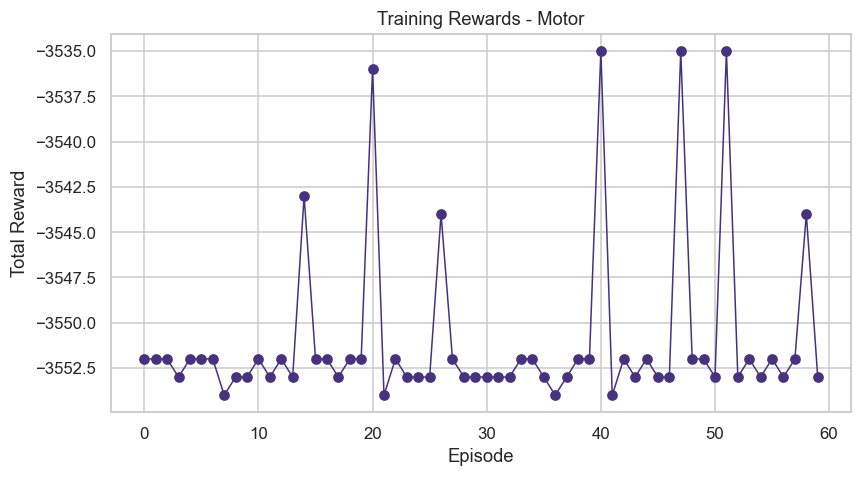


Training RL agent for capacitor (n_assets=1000)...


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/60 - Avg Reward (last 10): -1200.00 - Epsilon: 1.0000
Episode 10/60 - Avg Reward (last 10): -1201.30 - Epsilon: 0.8647
Episode 20/60 - Avg Reward (last 10): -1200.00 - Epsilon: 0.6401
Episode 30/60 - Avg Reward (last 10): -1200.90 - Epsilon: 0.4738
Episode 40/60 - Avg Reward (last 10): -1201.10 - Epsilon: 0.3508
Episode 50/60 - Avg Reward (last 10): -1198.50 - Epsilon: 0.2597
Episode 60/60 - Avg Reward (last 10): -1200.90 - Epsilon: 0.1922


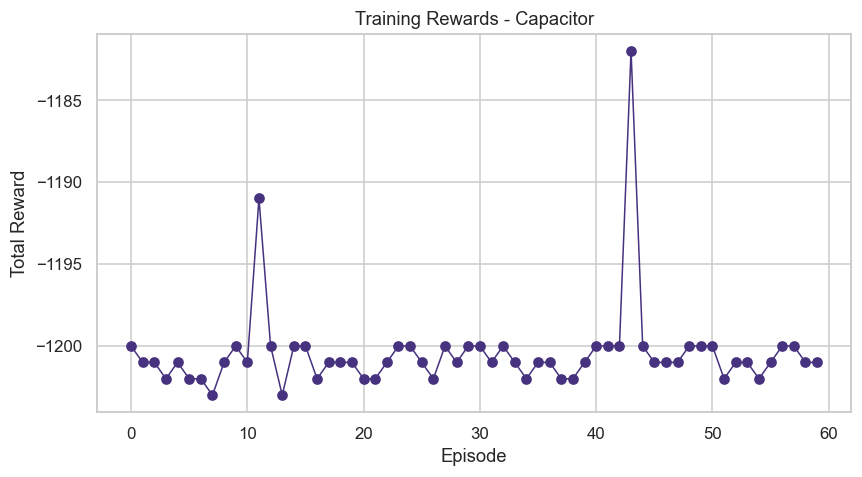


Training RL agent for ups (n_assets=1000)...


c:\Users\Crypto\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/60 - Avg Reward (last 10): -1489.00 - Epsilon: 1.0000
Episode 10/60 - Avg Reward (last 10): -1486.80 - Epsilon: 0.8647
Episode 20/60 - Avg Reward (last 10): -1488.60 - Epsilon: 0.6401
Episode 30/60 - Avg Reward (last 10): -1489.10 - Epsilon: 0.4738
Episode 40/60 - Avg Reward (last 10): -1488.90 - Epsilon: 0.3508
Episode 50/60 - Avg Reward (last 10): -1488.80 - Epsilon: 0.2597
Episode 60/60 - Avg Reward (last 10): -1487.50 - Epsilon: 0.1922


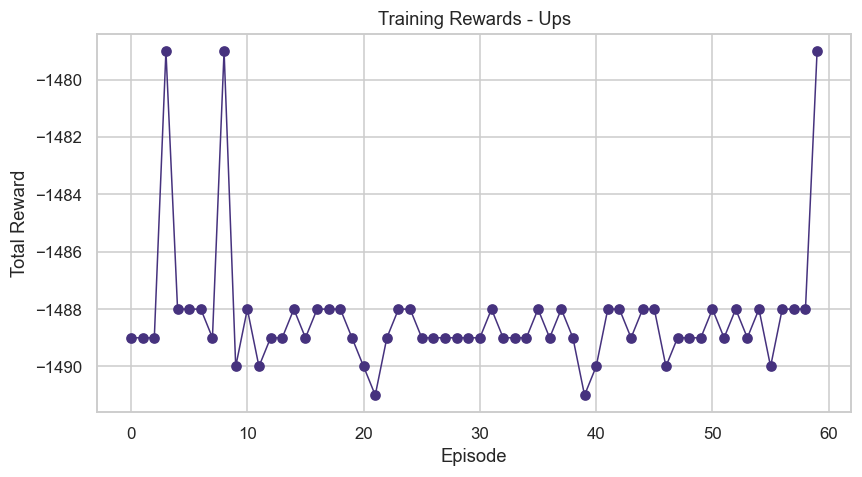

In [5]:
# 3. Train RL Agents for Each Asset Type
print("\nTraining RL agents for maintenance scheduling...")

MAINTENANCE_COSTS = {
    'transformer': 3500,
    'motor': 2800,
    'capacitor': 1800,
    'ups': 2200
}
PRODUCTION_IMPACT = {
    'transformer': 15000,
    'motor': 12000,
    'capacitor': 8000,
    'ups': 10000
}
resource_availability = [0.8, 0.6, 0.9, 0.7, 0.5, 0.4, 0.9]  # per-day resource units

rl_agents = {}
optimized_schedules = {}

for asset_type, failure_df in failure_data.items():
    print(f"\nTraining RL agent for {asset_type} (n_assets={len(failure_df)})...")
    if len(failure_df) == 0:
        warnings.warn(f"No failure data for {asset_type}. Skipping.")
        continue

    scheduler = MaintenanceScheduler(state_size=6, action_size=len(failure_df)*7)
    maintenance_costs = [MAINTENANCE_COSTS[asset_type]] * len(failure_df)
    production_impact = [PRODUCTION_IMPACT[asset_type]] * len(failure_df)

    schedule = scheduler.optimize_schedule(
        failure_df,
        maintenance_costs,
        production_impact,
        resource_availability.copy(),
        time_horizon=7,
        episodes=60  # keep modest for notebook responsiveness
    )

    rl_agents[asset_type] = scheduler
    optimized_schedules[asset_type] = schedule

    # Save model weights (Keras)
    try:
        scheduler.model.save(f'../models/rl_scheduler_{asset_type}.h5')
    except Exception as e:
        warnings.warn(f"Could not save Keras model for {asset_type}: {e}")

    # Plot training rewards inline (if present)
    if len(scheduler.training_rewards) > 0:
        plt.figure(figsize=(8, 4.5))
        plt.plot(scheduler.training_rewards, marker='o', linewidth=1)
        plt.title(f'Training Rewards - {asset_type.capitalize()}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.tight_layout()
        plt.savefig(f'../results/rl_training_progress_{asset_type}.png', dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()



Visualizing optimized maintenance schedules (diagnose & fallback) ...

--- TRANSFORMER ---
Schedule shape: (1000, 7); failure_df rows: 1000
Total scheduled events (from RL): 1


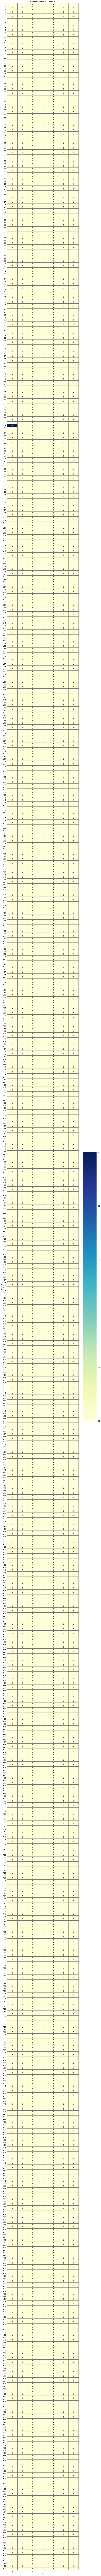

[saved] ../results/maintenance_schedule_transformer.png


value
n_assets                1000.0000
time_horizon               7.0000
maintenance_count          1.0000
maintenance_rate           0.0001
critical_coverage          0.0000
warning_coverage           0.0000
healthy_rate               0.0010
maintenance_cost        3500.0000
potential_avoided_loss     0.0000
estimated_roi              0.0000

asset_id current_health  failure_prob  time_to_failure  any_maintenance  \
0          0        Healthy      0.000000        15.000000                0   
1          1        Healthy      0.000000        15.000000                0   
2          2        Healthy      0.000000        15.000000                0   
3          3        Healthy      0.000000        15.000000                0   
4          4        Healthy      0.000000        15.000000                0   
5          5        Healthy      0.000000        15.000000                0   
6          6        Healthy      0.000000        15.000000                0   
7          7        Healthy      0.003383        14.983083                0   
8          8        Healthy      0.000000        15.000000                0   
9          9        Healthy      0.000000        15.000000                0   
10        10        Healthy      0.000000        15.000000                0   
11        11        Healthy      0.000000        15.000000                0   
12        12        Healthy      0.000000        15.000000                0   
13        13        Healthy      0.000000        15.000000                0   
14        14        Healthy      0.010150        14.949248                0   
15        15        Healthy      0.000000        15.000000                0   
16        16        Healthy      0.000000        15.000000                0   
17        17        Healthy      0.000000        15.000000                0   
18        18        Healthy      0.000000        15.000000                0   
19        19        Healthy      0.000000        15.000000                0   
20        20        Healthy      0.000000        15.000000                0   
21        21        Healthy      0.000000        15.000000                0   
22        22        Healthy      0.000000        15.000000                0   
23        23        Healthy      0.000000        15.000000                0   
24        24        Healthy      0.000000        15.000000                0   
25        25        Healthy      0.000000        15.000000                0   
26        26        Healthy      0.000000        15.000000                0   
27        27        Healthy      0.000000        15.000000                0   
28        28        Healthy      0.000000        15.000000                0   
29        29        Healthy      0.000000        15.000000                0   

    total_maint_slots  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0  
20                  0  
21                  0  
22                  0  
23                  0  
24                  0  
25                  0  
26                  0  
27                  0  
28                  0  
29                  0


--- MOTOR ---
Schedule shape: (1000, 7); failure_df rows: 1000
Total scheduled events (from RL): 0
Greedy fallback assigned total events: 6


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\4090706509.py:169: UserWarning: RL-generated schedule for 'motor' is empty. Building greedy fallback schedule.
  warnings.warn(f"RL-generated schedule for '{asset_type}' is empty. Building greedy fallback schedule.")


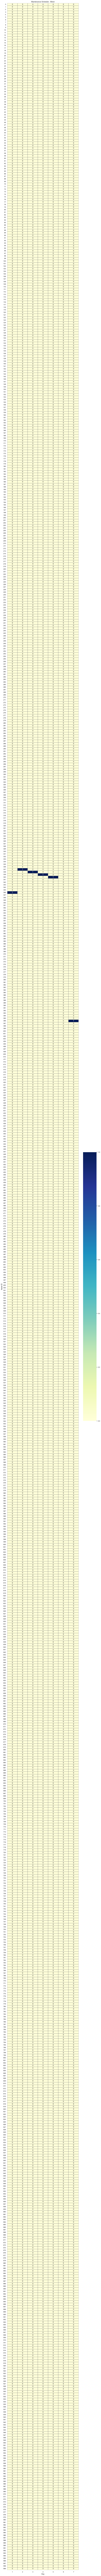

[saved] ../results/maintenance_schedule_motor.png


value
n_assets                1.000000e+03
time_horizon            7.000000e+00
maintenance_count       6.000000e+00
maintenance_rate        9.000000e-04
critical_coverage       9.380000e-02
warning_coverage        0.000000e+00
healthy_rate            0.000000e+00
maintenance_cost        1.680000e+04
potential_avoided_loss  1.209600e+07
estimated_roi           7.200000e+02

asset_id current_health  failure_prob  time_to_failure  any_maintenance  \
0          0        Healthy           0.0             15.0                0   
1          1        Healthy           0.0             15.0                0   
2          2        Healthy           0.0             15.0                0   
3          3        Healthy           0.0             15.0                0   
4          4        Healthy           0.0             15.0                0   
5          5        Healthy           0.0             15.0                0   
6          6        Healthy           0.0             15.0                0   
7          7        Healthy           0.0             15.0                0   
8          8        Healthy           0.0             15.0                0   
9          9        Healthy           0.0             15.0                0   
10        10        Healthy           0.0             15.0                0   
11        11        Healthy           0.0             15.0                0   
12        12        Healthy           0.0             15.0                0   
13        13        Healthy           0.0             15.0                0   
14        14        Healthy           0.0             15.0                0   
15        15        Healthy           0.0             15.0                0   
16        16        Healthy           0.0             15.0                0   
17        17        Healthy           0.0             15.0                0   
18        18        Healthy           0.0             15.0                0   
19        19        Healthy           0.0             15.0                0   
20        20        Healthy           0.0             15.0                0   
21        21        Healthy           0.0             15.0                0   
22        22        Healthy           0.0             15.0                0   
23        23        Healthy           0.0             15.0                0   
24        24        Healthy           0.0             15.0                0   
25        25        Healthy           0.0             15.0                0   
26        26        Healthy           0.0             15.0                0   
27        27        Healthy           0.0             15.0                0   
28        28        Healthy           0.0             15.0                0   
29        29        Healthy           0.0             15.0                0   

    total_maint_slots  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0  
20                  0  
21                  0  
22                  0  
23                  0  
24                  0  
25                  0  
26                  0  
27                  0  
28                  0  
29                  0


--- CAPACITOR ---
Schedule shape: (1000, 7); failure_df rows: 1000
Total scheduled events (from RL): 2


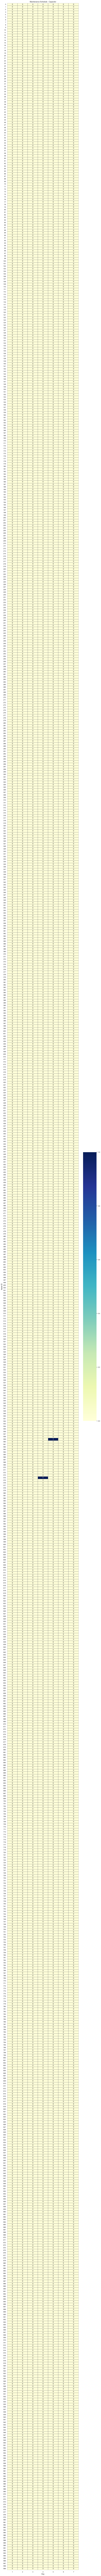

[saved] ../results/maintenance_schedule_capacitor.png


value
n_assets                1000.0000
time_horizon               7.0000
maintenance_count          2.0000
maintenance_rate           0.0003
critical_coverage          0.0000
warning_coverage           0.0000
healthy_rate               0.0021
maintenance_cost        3600.0000
potential_avoided_loss     0.0000
estimated_roi              0.0000

asset_id current_health  failure_prob  time_to_failure  any_maintenance  \
0          0        Healthy           0.0             15.0                0   
1          1        Healthy           0.0             15.0                0   
2          2        Healthy           0.0             15.0                0   
3          3        Healthy           0.0             15.0                0   
4          4        Healthy           0.0             15.0                0   
5          5        Healthy           0.0             15.0                0   
6          6        Healthy           0.0             15.0                0   
7          7        Healthy           0.0             15.0                0   
8          8        Healthy           0.0             15.0                0   
9          9        Healthy           0.0             15.0                0   
10        10        Healthy           0.0             15.0                0   
11        11        Healthy           0.0             15.0                0   
12        12        Healthy           0.0             15.0                0   
13        13        Healthy           0.0             15.0                0   
14        14        Healthy           0.0             15.0                0   
15        15        Healthy           0.0             15.0                0   
16        16        Healthy           0.0             15.0                0   
17        17        Healthy           0.0             15.0                0   
18        18        Healthy           0.0             15.0                0   
19        19        Healthy           0.0             15.0                0   
20        20        Healthy           0.0             15.0                0   
21        21        Healthy           0.0             15.0                0   
22        22        Healthy           0.0             15.0                0   
23        23        Healthy           0.0             15.0                0   
24        24        Healthy           0.0             15.0                0   
25        25        Healthy           0.0             15.0                0   
26        26        Healthy           0.0             15.0                0   
27        27        Healthy           0.0             15.0                0   
28        28        Healthy           0.0             15.0                0   
29        29        Healthy           0.0             15.0                0   

    total_maint_slots  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0  
20                  0  
21                  0  
22                  0  
23                  0  
24                  0  
25                  0  
26                  0  
27                  0  
28                  0  
29                  0


--- UPS ---
Schedule shape: (1000, 7); failure_df rows: 1000
Total scheduled events (from RL): 1


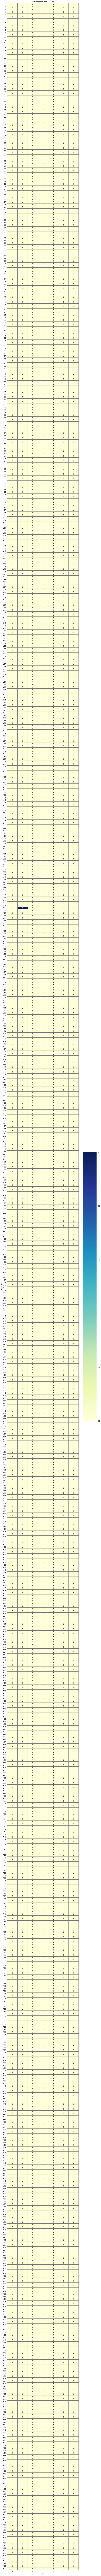

[saved] ../results/maintenance_schedule_ups.png


value
n_assets                1000.0000
time_horizon               7.0000
maintenance_count          1.0000
maintenance_rate           0.0001
critical_coverage          0.0000
warning_coverage           0.0000
healthy_rate               0.0011
maintenance_cost        2200.0000
potential_avoided_loss     0.0000
estimated_roi              0.0000

asset_id current_health  failure_prob  time_to_failure  any_maintenance  \
0          0        Healthy      0.000000        15.000000                0   
1          1        Healthy      0.000000        15.000000                0   
2          2        Healthy      0.015815        14.920926                0   
3          3        Healthy      0.000000        15.000000                0   
4          4        Healthy      0.000000        15.000000                0   
5          5        Healthy      0.000000        15.000000                0   
6          6        Healthy      0.000000        15.000000                0   
7          7        Healthy      0.017844        14.910779                0   
8          8        Healthy      0.000000        15.000000                0   
9          9        Healthy      0.000000        15.000000                0   
10        10        Healthy      0.000000        15.000000                0   
11        11        Healthy      0.000000        15.000000                0   
12        12        Healthy      0.000000        15.000000                0   
13        13        Healthy      0.000000        15.000000                0   
14        14        Healthy      0.000000        15.000000                0   
15        15        Healthy      0.000000        15.000000                0   
16        16        Healthy      0.000000        15.000000                0   
17        17        Healthy      0.000000        15.000000                0   
18        18        Healthy      0.000000        15.000000                0   
19        19        Healthy      0.000000        15.000000                0   
20        20        Healthy      0.000000        15.000000                0   
21        21        Healthy      0.000000        15.000000                0   
22        22        Healthy      0.012304        14.938479                0   
23        23        Healthy      0.000000        15.000000                0   
24        24        Healthy      0.000000        15.000000                0   
25        25        Healthy      0.000000        15.000000                0   
26        26        Healthy      0.000000        15.000000                0   
27        27        Healthy      0.000000        15.000000                0   
28        28        Healthy      0.000000        15.000000                0   
29        29        Healthy      0.000000        15.000000                0   

    total_maint_slots  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
5                   0  
6                   0  
7                   0  
8                   0  
9                   0  
10                  0  
11                  0  
12                  0  
13                  0  
14                  0  
15                  0  
16                  0  
17                  0  
18                  0  
19                  0  
20                  0  
21                  0  
22                  0  
23                  0  
24                  0  
25                  0  
26                  0  
27                  0  
28                  0  
29                  0

In [20]:
# 4. Schedule Visualization and Analysis (diagnose + fallback) — fixed day ticks (1..time_horizon)
from IPython.display import display, HTML
import warnings
import numpy as np

print("\nVisualizing optimized maintenance schedules (diagnose & fallback) ...")

def plot_schedule(schedule, asset_type, title=None, show_plot=True):
    """Heatmap plot with consistent formatting for Jupyter and day ticks 1..T."""
    schedule = np.asarray(schedule).astype(int)
    # Ensure 2D
    if schedule.ndim == 1:
        schedule = schedule.reshape(-1, 1)

    n_rows, n_cols = schedule.shape
    plt.figure(figsize=(10, max(3.5, n_rows * 0.25)))
    ax = sns.heatmap(schedule, annot=True, fmt='.0f', cmap='YlGnBu', cbar=True, vmin=0, vmax=1,
                     linewidths=0.3, linecolor='gray')
    ax.set_title(title or f'Maintenance Schedule - {asset_type.capitalize()}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Asset ID')

    # Set x ticks to 1..n_cols (not 0..)
    ax.set_xticks(np.arange(n_cols) + 0.5)            # center ticks
    ax.set_xticklabels([str(i) for i in range(1, n_cols + 1)], rotation=0)

    # Set y tick labels to asset ids (0..n_rows-1) but keep rotation 0
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels([str(i) for i in range(0, n_rows)], rotation=0)

    plt.tight_layout()
    out_file = f'../results/maintenance_schedule_{asset_type}.png'
    plt.savefig(out_file, dpi=200, bbox_inches='tight')
    if show_plot:
        plt.show()
    plt.close()
    print(f"[saved] {out_file}")

def build_greedy_fallback_schedule(failure_df, time_horizon, resource_availability, per_asset_once=True):
    """
    Greedy fallback: each day schedule the highest failure_prob assets while resources remain.
    Pads resource_availability if shorter than time_horizon.
    """
    n_assets = len(failure_df)
    fallback = np.zeros((n_assets, time_horizon), dtype=int)

    # Ensure resource_availability length matches time_horizon
    resources = list(resource_availability)
    if len(resources) < time_horizon:
        if len(resources) == 0:
            resources = [0.5] * time_horizon
        else:
            last = resources[-1]
            resources = resources + [last] * (time_horizon - len(resources))
    elif len(resources) > time_horizon:
        resources = resources[:time_horizon]

    # sort assets once by failure_prob descending and keep original indices
    ordered = failure_df.reset_index().sort_values('failure_prob', ascending=False).reset_index(drop=True)
    used_assets = set()

    for day in range(time_horizon):
        # assign as many assets as resources allow (each maintenance costs 0.5)
        while resources[day] >= 0.5:
            picked = None
            for _, row in ordered.iterrows():
                idx = int(row['index'])
                if per_asset_once and idx in used_assets:
                    continue
                if fallback[idx, day] == 0:
                    picked = idx
                    break
            if picked is None:
                break
            fallback[picked, day] = 1
            used_assets.add(picked)
            resources[day] = max(0.0, resources[day] - 0.5)
    return fallback

def analyze_schedule_with_debug(schedule, failure_df, asset_type, resource_availability):
    """Analyze schedule, print diagnostics, and return report (with per-asset summary)."""
    schedule = np.asarray(schedule).astype(int)
    if schedule.ndim == 1:
        schedule = schedule.reshape(-1, 1)
    if schedule.ndim != 2:
        raise ValueError("schedule must be 2D (n_assets x time_horizon).")

    n_assets, time_horizon = schedule.shape

    # Align lengths if mismatch
    if len(failure_df) != n_assets:
        warnings.warn(f"Length mismatch: failure_df {len(failure_df)} rows vs schedule {n_assets} rows. Truncating to min.")
        min_n = min(len(failure_df), n_assets)
        failure_df = failure_df.iloc[:min_n].reset_index(drop=True)
        schedule = schedule[:min_n, :]
        n_assets = min_n

    maintenance_mask = (schedule > 0)
    maintenance_count = int(np.sum(maintenance_mask))
    maintenance_rate = maintenance_count / float(n_assets * time_horizon) if (n_assets * time_horizon) > 0 else 0.0
    per_asset_any = maintenance_mask.sum(axis=1) > 0

    # indices by health
    critical_idx = failure_df.index[failure_df['current_health'] == 'Critical'].tolist()
    warning_idx = failure_df.index[failure_df['current_health'] == 'Warning'].tolist()
    healthy_idx = failure_df.index[failure_df['current_health'] == 'Healthy'].tolist()

    critical_coverage = (np.sum(per_asset_any[critical_idx]) / len(critical_idx)) if len(critical_idx) > 0 else 0.0
    warning_coverage = (np.sum(per_asset_any[warning_idx]) / len(warning_idx)) if len(warning_idx) > 0 else 0.0
    healthy_rate = (np.sum(per_asset_any[healthy_idx]) / len(healthy_idx)) if len(healthy_idx) > 0 else 0.0

    unit_cost = MAINTENANCE_COSTS.get(asset_type, 0)
    maintenance_cost = maintenance_count * unit_cost

    potential_avoided_loss = 0.0
    for i in range(n_assets):
        if per_asset_any[i]:
            health = failure_df.iloc[i]['current_health']
            if health == 'Critical':
                potential_avoided_loss += PRODUCTION_IMPACT[asset_type] * 24 * 7
            elif health == 'Warning':
                potential_avoided_loss += PRODUCTION_IMPACT[asset_type] * 24 * 3

    estimated_roi = potential_avoided_loss / maintenance_cost if maintenance_cost > 0 else np.nan

    # Diagnostics
    diag = {
        'n_assets': n_assets,
        'time_horizon': time_horizon,
        'maintenance_count': maintenance_count,
        'maintenance_rate': maintenance_rate,
        'critical_coverage': float(critical_coverage),
        'warning_coverage': float(warning_coverage),
        'healthy_rate': float(healthy_rate),
        'maintenance_cost': float(maintenance_cost),
        'potential_avoided_loss': float(potential_avoided_loss),
        'estimated_roi': float(estimated_roi) if not np.isnan(estimated_roi) else np.nan,
        'per_asset_summary': pd.DataFrame({
            'asset_id': failure_df['asset_id'].values,
            'current_health': failure_df['current_health'].values,
            'failure_prob': failure_df['failure_prob'].values,
            'time_to_failure': failure_df['time_to_failure'].values,
            'any_maintenance': per_asset_any.astype(int),
            'total_maint_slots': maintenance_mask.sum(axis=1).astype(int)
        })
    }
    return diag

# Run analysis, diagnose, and fallback if empty schedules produced
schedule_analysis = {}
for asset_type, orig_schedule in optimized_schedules.items():
    print(f"\n--- {asset_type.upper()} ---")
    schedule = np.asarray(orig_schedule).astype(int)
    if schedule.ndim == 1:
        # If user passed a 1D schedule, assume it's per-asset with single day and reshape
        schedule = schedule.reshape(-1, 1)

    failure_df = failure_data[asset_type].copy().reset_index(drop=True)
    # Basic info
    print(f"Schedule shape: {schedule.shape}; failure_df rows: {len(failure_df)}")

    # Quick debug: show total scheduled events
    total_events = int(np.sum(schedule))
    print(f"Total scheduled events (from RL): {total_events}")

    # If RL produced no events, build a greedy fallback and use it (but keep RL schedule saved too)
    time_horizon = schedule.shape[1] if schedule.size > 0 else 7
    if total_events == 0:
        warnings.warn(f"RL-generated schedule for '{asset_type}' is empty. Building greedy fallback schedule.")
        fallback = build_greedy_fallback_schedule(failure_df, time_horizon, resource_availability, per_asset_once=True)
        schedule_used = fallback
        np.save(f'../results/fallback_schedule_{asset_type}.npy', fallback)
        print(f"Greedy fallback assigned total events: {int(np.sum(fallback))}")
    else:
        schedule_used = schedule

    # Plot used schedule (days will be labeled 1..time_horizon)
    plot_schedule(schedule_used, asset_type, show_plot=True)

    # Analyze used schedule
    report = analyze_schedule_with_debug(schedule_used, failure_df, asset_type, resource_availability)
    schedule_analysis[asset_type] = report

    # Present metrics and per-asset summary
    display(HTML(f"<h4>{asset_type.capitalize()} Schedule Metrics</h4>"))
    metrics = {k: v for k, v in report.items() if k != 'per_asset_summary'}
    metrics_df = pd.DataFrame([metrics]).T.rename(columns={0:'value'})
    # round floats for neat display
    for col in metrics_df.index:
        if isinstance(metrics_df.loc[col, 'value'], float):
            metrics_df.loc[col, 'value'] = round(metrics_df.loc[col, 'value'], 4) if not np.isnan(metrics_df.loc[col, 'value']) else 'nan'
    display(metrics_df)

    display(HTML("<b>Per-asset summary (first 30 rows)</b>"))
    display(report['per_asset_summary'].head(30))


Comparing scheduling approaches (enhanced visuals)...


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\2397141401.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comparison_df[c].replace([np.inf, -np.inf], np.nan, inplace=True)


Asset Type Maintenance Rate Critical Coverage Warning Coverage  \
0  transformer            0.01%             0.00%            0.00%   
1        motor            0.09%             9.38%            0.00%   
2    capacitor            0.03%             0.00%            0.00%   
3          ups            0.01%             0.00%            0.00%   

  Healthy Rate  Estimated ROI  
0        0.10%            0.0  
1        0.00%          720.0  
2        0.21%            0.0  
3        0.11%            0.0

C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\2397141401.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, ax=ax, ci=None, palette='viridis')
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\2397141401.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, ax=ax, ci=None, palette='viridis')
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\2397141401.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=df, ax=ax, ci=None, palette='viridis')
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\2397141401.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

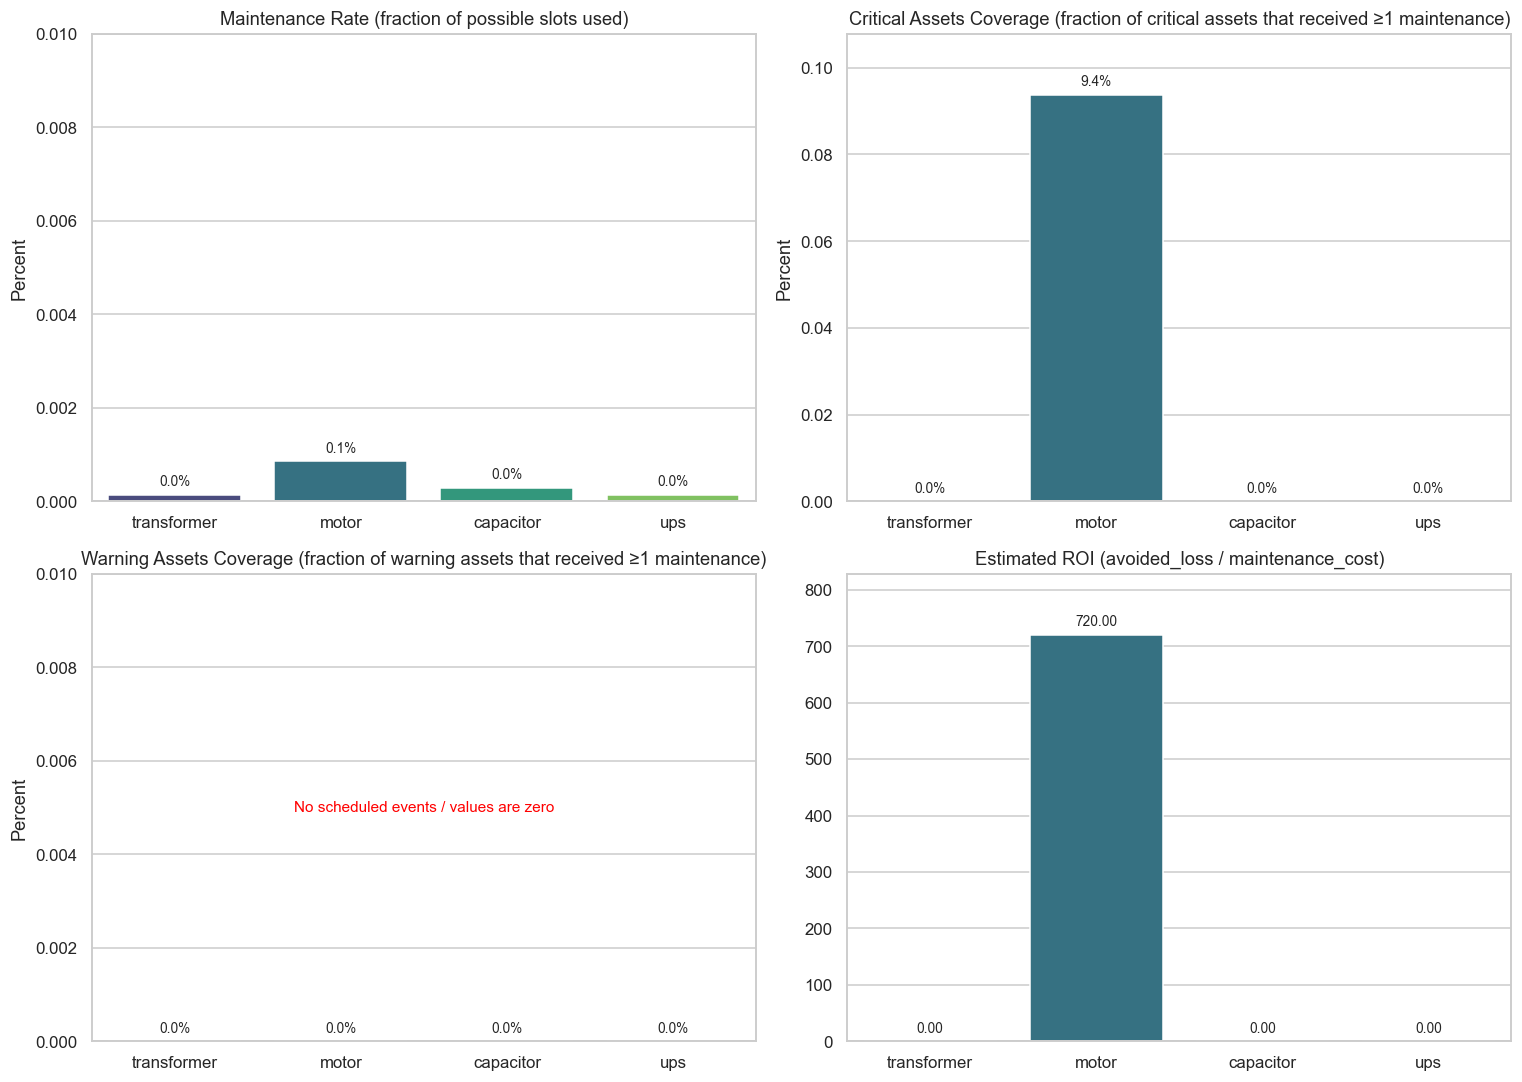

[saved] ../results/scheduling_comparison_enhanced.{png,csv}


In [22]:
# 5. Comparative Analysis of Scheduling Approaches (robust, annotated)
print("\nComparing scheduling approaches (enhanced visuals)...")

# Build comparison table from schedule_analysis (defensive)
comparison_rows = []
for asset_type, analysis in schedule_analysis.items():
    comparison_rows.append({
        'Asset Type': asset_type,
        'Maintenance Rate': analysis.get('maintenance_rate', np.nan),
        'Critical Coverage': analysis.get('critical_coverage', np.nan),
        'Warning Coverage': analysis.get('warning_coverage', np.nan),
        'Healthy Rate': analysis.get('healthy_rate', np.nan),
        'Estimated ROI': analysis.get('estimated_roi', np.nan)
    })

comparison_df = pd.DataFrame(comparison_rows)

# Ensure numeric types, handle inf/NaN
num_cols = ['Maintenance Rate', 'Critical Coverage', 'Warning Coverage', 'Healthy Rate', 'Estimated ROI']
for c in num_cols:
    comparison_df[c] = pd.to_numeric(comparison_df[c], errors='coerce')
    comparison_df[c].replace([np.inf, -np.inf], np.nan, inplace=True)

# Show table (with percentages for rates)
display(comparison_df.assign(
    **{col: (comparison_df[col].apply(lambda v: f"{v:.2%}" if pd.notna(v) and col != 'Estimated ROI' else (f"{v:.2f}" if pd.notna(v) else "nan"))
        ) for col in ['Maintenance Rate','Critical Coverage','Warning Coverage','Healthy Rate']}
))

# Plotting helper to annotate bars and show friendly message if no data
def annotated_barplot(ax, df, x_col, y_col, is_pct=True, ymax_pad=0.15):
    sns.barplot(x=x_col, y=y_col, data=df, ax=ax, ci=None, palette='viridis')
    ax.set_xlabel('')
    ax.set_ylabel('' if not is_pct else 'Percent')
    # convert to percent scale for display if is_pct
    vals = df[y_col].fillna(0).values
    # dynamic y-limit
    max_val = np.nanmax(vals) if len(vals) > 0 else 0
    if np.isnan(max_val):
        max_val = 0
    top = max(1.0, max_val * (1 + ymax_pad)) if not is_pct else max(0.01, max_val * (1 + ymax_pad))
    # if plotting percent we keep axis 0..1
    if is_pct:
        ax.set_ylim(0, min(1.0, top) if top <= 1.0 else 1.0)
    else:
        ax.set_ylim(0, top)

    # annotate bars
    for p, v in zip(ax.patches, vals):
        if is_pct:
            txt = f"{v*100:0.1f}%"
        else:
            txt = f"{v:0.2f}"
        # place text a little above bar or at center if bar small
        height = p.get_height()
        ax.annotate(txt, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 4), textcoords='offset points')
    # if all zeros / NaN show hint text
    if np.nanmax(vals) == 0:
        ax.text(0.5, 0.5, "No scheduled events / values are zero", ha='center', va='center', transform=ax.transAxes, color='red', fontsize=10)

# Create figure and subplots
plt.figure(figsize=(14, 10))

# Maintenance Rate (percentage)
ax1 = plt.subplot(2, 2, 1)
annotated_barplot(ax1, comparison_df, 'Asset Type', 'Maintenance Rate', is_pct=True)
ax1.set_title('Maintenance Rate (fraction of possible slots used)')

# Critical Coverage (percentage)
ax2 = plt.subplot(2, 2, 2)
annotated_barplot(ax2, comparison_df, 'Asset Type', 'Critical Coverage', is_pct=True)
ax2.set_title('Critical Assets Coverage (fraction of critical assets that received ≥1 maintenance)')

# Warning Coverage (percentage)
ax3 = plt.subplot(2, 2, 3)
annotated_barplot(ax3, comparison_df, 'Asset Type', 'Warning Coverage', is_pct=True)
ax3.set_title('Warning Assets Coverage (fraction of warning assets that received ≥1 maintenance)')

# Estimated ROI (numeric)
ax4 = plt.subplot(2, 2, 4)
annotated_barplot(ax4, comparison_df, 'Asset Type', 'Estimated ROI', is_pct=False)
ax4.set_title('Estimated ROI (avoided_loss / maintenance_cost)')

plt.tight_layout()
plt.savefig('../results/scheduling_comparison_enhanced.png', dpi=200, bbox_inches='tight')
plt.show()

# Save numeric CSV (raw numbers)
comparison_df.to_csv('../results/scheduling_comparison_enhanced.csv', index=False)
print("[saved] ../results/scheduling_comparison_enhanced.{png,csv}")


Analyzing resource utilization (fixed plots & robust counting)...

Analyzing resource utilization for transformer...


[saved] ../results/resource_utilization_transformer.csv


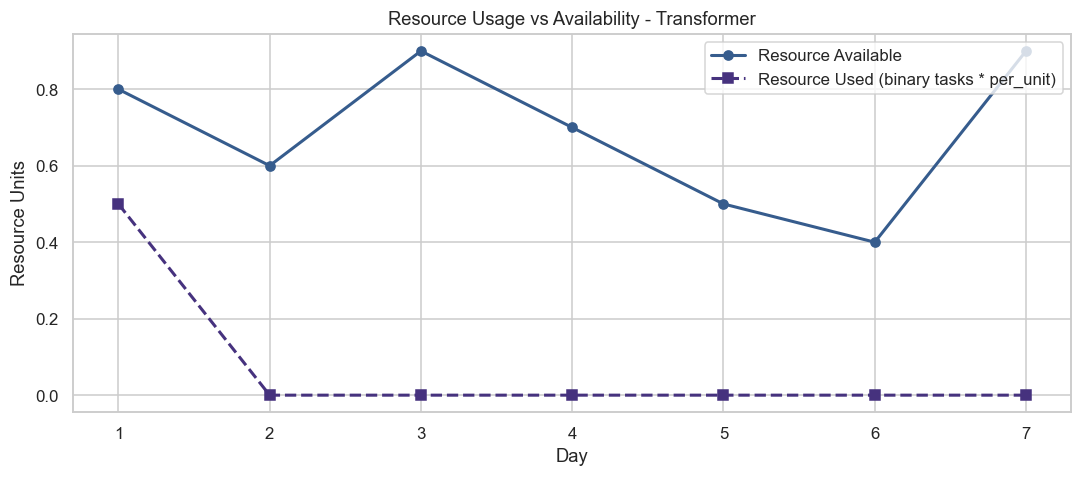

[saved] ../results/resource_utilization_plot_transformer.png


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(util)+1)), y=util, palette='viridis', ax=ax)
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(days)


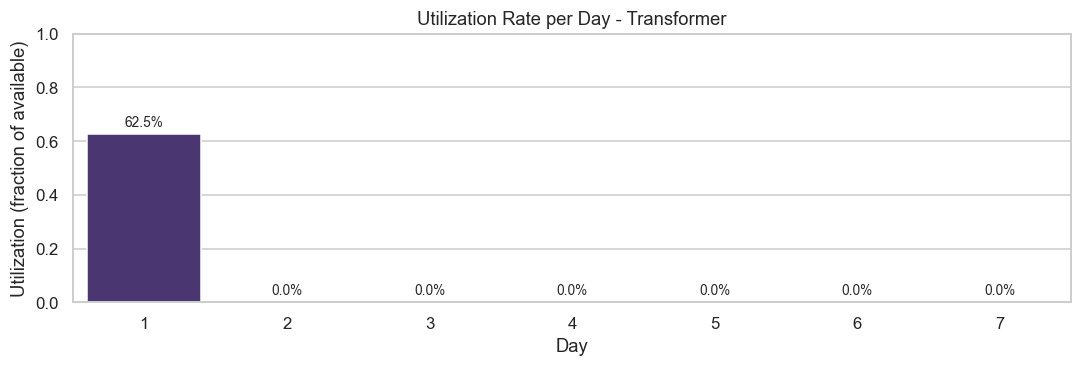

[saved] ../results/resource_utilization_bar_transformer.png


asset_id current_health  failure_prob  any_task  total_tasks
0          0        Healthy      0.000000     False            0
1          1        Healthy      0.000000     False            0
2          2        Healthy      0.000000     False            0
3          3        Healthy      0.000000     False            0
4          4        Healthy      0.000000     False            0
5          5        Healthy      0.000000     False            0
6          6        Healthy      0.000000     False            0
7          7        Healthy      0.003383     False            0
8          8        Healthy      0.000000     False            0
9          9        Healthy      0.000000     False            0
10        10        Healthy      0.000000     False            0
11        11        Healthy      0.000000     False            0
12        12        Healthy      0.000000     False            0
13        13        Healthy      0.000000     False            0
14        14        Healthy      0.010150     False            0
15        15        Healthy      0.000000     False            0
16        16        Healthy      0.000000     False            0
17        17        Healthy      0.000000     False            0
18        18        Healthy      0.000000     False            0
19        19        Healthy      0.000000     False            0
20        20        Healthy      0.000000     False            0
21        21        Healthy      0.000000     False            0
22        22        Healthy      0.000000     False            0
23        23        Healthy      0.000000     False            0
24        24        Healthy      0.000000     False            0
25        25        Healthy      0.000000     False            0
26        26        Healthy      0.000000     False            0
27        27        Healthy      0.000000     False            0
28        28        Healthy      0.000000     False            0
29        29        Healthy      0.000000     False            0

[saved] ../results/per_asset_debug_transformer.csv


value
avg_utilization_rate  0.089286
days_overutilized     0.000000
total_shortfall       0.000000


Analyzing resource utilization for motor...


[saved] ../results/resource_utilization_motor.csv


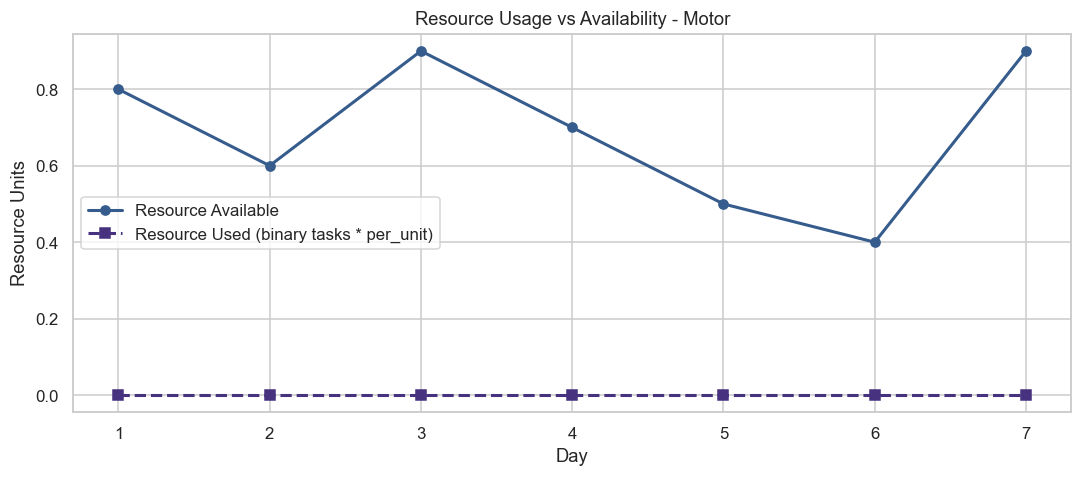

[saved] ../results/resource_utilization_plot_motor.png


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(util)+1)), y=util, palette='viridis', ax=ax)
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(days)


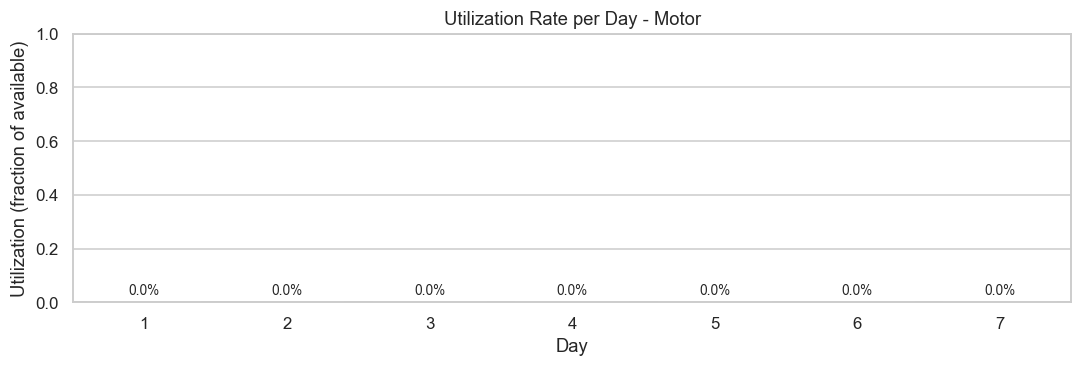

[saved] ../results/resource_utilization_bar_motor.png


asset_id current_health  failure_prob  any_task  total_tasks
0          0        Healthy           0.0     False            0
1          1        Healthy           0.0     False            0
2          2        Healthy           0.0     False            0
3          3        Healthy           0.0     False            0
4          4        Healthy           0.0     False            0
5          5        Healthy           0.0     False            0
6          6        Healthy           0.0     False            0
7          7        Healthy           0.0     False            0
8          8        Healthy           0.0     False            0
9          9        Healthy           0.0     False            0
10        10        Healthy           0.0     False            0
11        11        Healthy           0.0     False            0
12        12        Healthy           0.0     False            0
13        13        Healthy           0.0     False            0
14        14        Healthy           0.0     False            0
15        15        Healthy           0.0     False            0
16        16        Healthy           0.0     False            0
17        17        Healthy           0.0     False            0
18        18        Healthy           0.0     False            0
19        19        Healthy           0.0     False            0
20        20        Healthy           0.0     False            0
21        21        Healthy           0.0     False            0
22        22        Healthy           0.0     False            0
23        23        Healthy           0.0     False            0
24        24        Healthy           0.0     False            0
25        25        Healthy           0.0     False            0
26        26        Healthy           0.0     False            0
27        27        Healthy           0.0     False            0
28        28        Healthy           0.0     False            0
29        29        Healthy           0.0     False            0

[saved] ../results/per_asset_debug_motor.csv


value
avg_utilization_rate    0.0
days_overutilized       0.0
total_shortfall         0.0


Analyzing resource utilization for capacitor...


[saved] ../results/resource_utilization_capacitor.csv


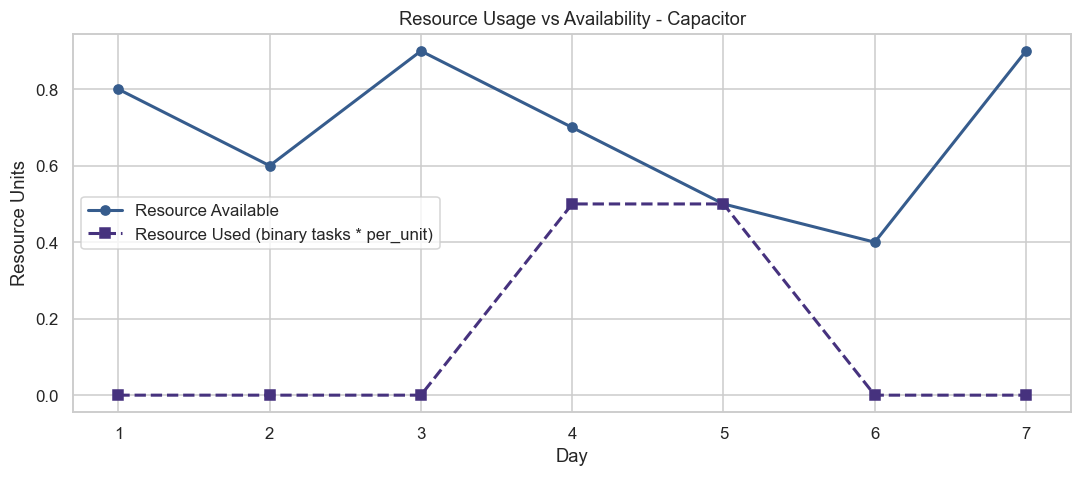

[saved] ../results/resource_utilization_plot_capacitor.png


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(util)+1)), y=util, palette='viridis', ax=ax)
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(days)


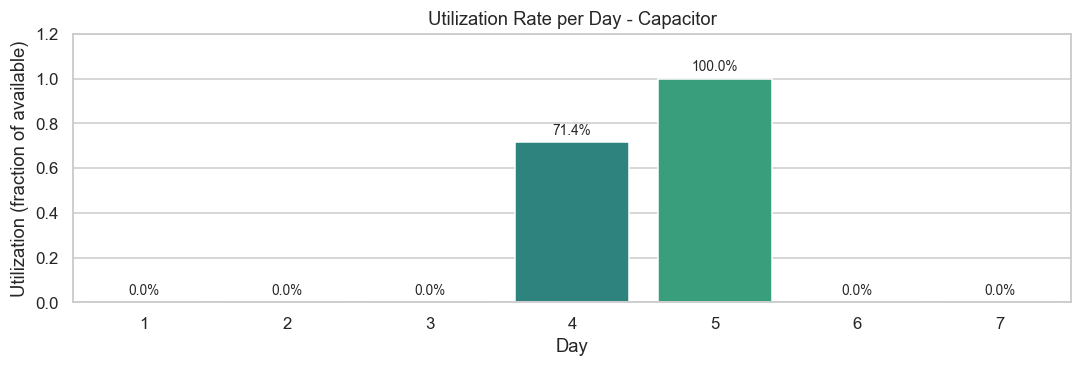

[saved] ../results/resource_utilization_bar_capacitor.png


asset_id current_health  failure_prob  any_task  total_tasks
0          0        Healthy           0.0     False            0
1          1        Healthy           0.0     False            0
2          2        Healthy           0.0     False            0
3          3        Healthy           0.0     False            0
4          4        Healthy           0.0     False            0
5          5        Healthy           0.0     False            0
6          6        Healthy           0.0     False            0
7          7        Healthy           0.0     False            0
8          8        Healthy           0.0     False            0
9          9        Healthy           0.0     False            0
10        10        Healthy           0.0     False            0
11        11        Healthy           0.0     False            0
12        12        Healthy           0.0     False            0
13        13        Healthy           0.0     False            0
14        14        Healthy           0.0     False            0
15        15        Healthy           0.0     False            0
16        16        Healthy           0.0     False            0
17        17        Healthy           0.0     False            0
18        18        Healthy           0.0     False            0
19        19        Healthy           0.0     False            0
20        20        Healthy           0.0     False            0
21        21        Healthy           0.0     False            0
22        22        Healthy           0.0     False            0
23        23        Healthy           0.0     False            0
24        24        Healthy           0.0     False            0
25        25        Healthy           0.0     False            0
26        26        Healthy           0.0     False            0
27        27        Healthy           0.0     False            0
28        28        Healthy           0.0     False            0
29        29        Healthy           0.0     False            0

[saved] ../results/per_asset_debug_capacitor.csv


value
avg_utilization_rate  0.244898
days_overutilized     0.000000
total_shortfall       0.000000


Analyzing resource utilization for ups...


[saved] ../results/resource_utilization_ups.csv


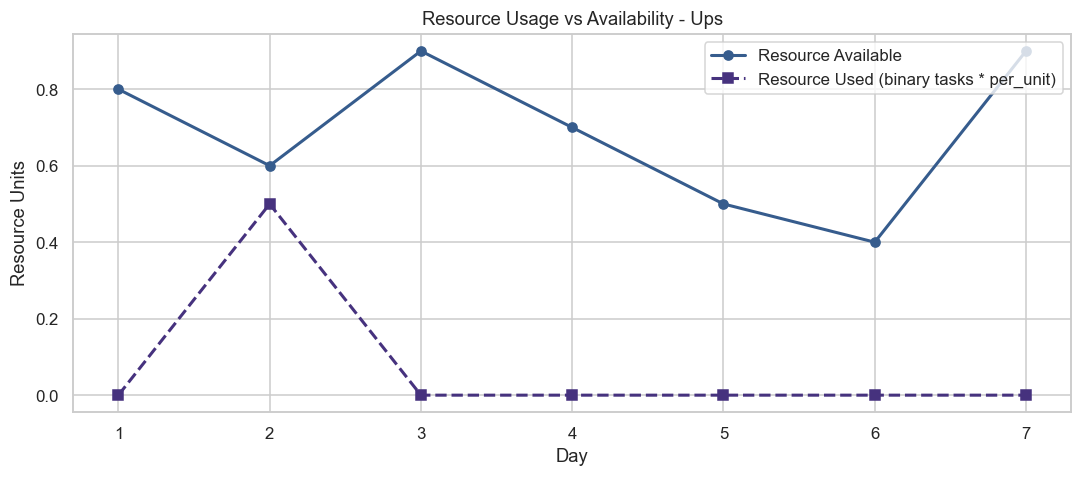

[saved] ../results/resource_utilization_plot_ups.png


C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(util)+1)), y=util, palette='viridis', ax=ax)
C:\Users\Crypto\AppData\Local\Temp\ipykernel_9308\27683556.py:155: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(days)


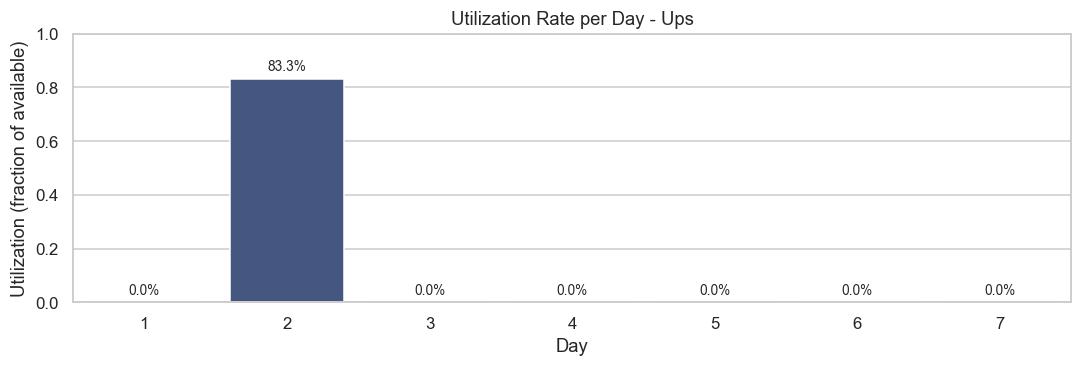

[saved] ../results/resource_utilization_bar_ups.png


asset_id current_health  failure_prob  any_task  total_tasks
0          0        Healthy      0.000000     False            0
1          1        Healthy      0.000000     False            0
2          2        Healthy      0.015815     False            0
3          3        Healthy      0.000000     False            0
4          4        Healthy      0.000000     False            0
5          5        Healthy      0.000000     False            0
6          6        Healthy      0.000000     False            0
7          7        Healthy      0.017844     False            0
8          8        Healthy      0.000000     False            0
9          9        Healthy      0.000000     False            0
10        10        Healthy      0.000000     False            0
11        11        Healthy      0.000000     False            0
12        12        Healthy      0.000000     False            0
13        13        Healthy      0.000000     False            0
14        14        Healthy      0.000000     False            0
15        15        Healthy      0.000000     False            0
16        16        Healthy      0.000000     False            0
17        17        Healthy      0.000000     False            0
18        18        Healthy      0.000000     False            0
19        19        Healthy      0.000000     False            0
20        20        Healthy      0.000000     False            0
21        21        Healthy      0.000000     False            0
22        22        Healthy      0.012304     False            0
23        23        Healthy      0.000000     False            0
24        24        Healthy      0.000000     False            0
25        25        Healthy      0.000000     False            0
26        26        Healthy      0.000000     False            0
27        27        Healthy      0.000000     False            0
28        28        Healthy      0.000000     False            0
29        29        Healthy      0.000000     False            0

[saved] ../results/per_asset_debug_ups.csv


value
avg_utilization_rate  0.119048
days_overutilized     0.000000
total_shortfall       0.000000


Resource utilization analysis completed. Plots & CSVs saved to ../results.


In [23]:
# 6. Resource Utilization Analysis (fixed shortfall plotting + robust usage counting)
print("\nAnalyzing resource utilization (fixed plots & robust counting)...")

from IPython.display import display, HTML

# Parameters
PER_TASK_RESOURCE_UNIT = 0.5  # resource units consumed per scheduled maintenance event

def _safe_array(x):
    arr = np.asarray(x)
    if arr.size == 0:
        return arr.astype(float)
    return arr.astype(float)

def analyze_resource_utilization(schedule, resource_availability, per_unit=PER_TASK_RESOURCE_UNIT):
    """
    Returns:
      - daily_utilization_raw: sum of raw schedule values per day (useful if schedule contains weights)
      - daily_tasks_binary: count of assets considered 'scheduled' per day (thresholded)
      - resource_usage: daily resource usage in units (based on binary tasks * per_unit)
      - resource_available: aligned resource_availability array
      - utilization_rate: resource_usage / resource_available (safe division)
      - shortfall: positive (usage - available), 0 otherwise
    """
    sched = np.asarray(schedule)
    if sched.ndim != 2:
        raise ValueError("schedule must be 2D (n_assets x time_horizon)")

    # align/clean schedule: convert nan to 0
    sched = np.nan_to_num(sched, nan=0.0)
    n_assets, time_horizon = sched.shape

    # Align resource availability length: pad with last value or truncate
    res = _safe_array(resource_availability)
    if res.size < time_horizon:
        if res.size == 0:
            res = np.full(time_horizon, 1.0)  # fallback
        else:
            res = np.concatenate([res, np.full(time_horizon - res.size, res[-1])])
    elif res.size > time_horizon:
        res = res[:time_horizon]

    # 1) Raw utilization (sum of raw schedule numbers) — helps debug fractional schedules
    daily_utilization_raw = np.sum(sched, axis=0)

    # 2) Binary tasks count: consider a maintenance scheduled if value >= 0.5 (robust threshold)
    task_mask = (sched >= 0.5).astype(int)
    daily_tasks_binary = np.sum(task_mask, axis=0).astype(int)

    # 3) Resource usage uses the binary task count (keeps compatibility with earlier logic)
    resource_usage = daily_tasks_binary * per_unit

    # 4) Utilization rate (safe division)
    with np.errstate(divide='ignore', invalid='ignore'):
        utilization_rate = np.divide(resource_usage, res, out=np.zeros_like(resource_usage, dtype=float), where=res!=0)

    # 5) Shortfall (positive only)
    shortfall = np.maximum(resource_usage - res, 0.0)
    total_shortfall = float(np.sum(shortfall))
    days_overutilized = int(np.sum(shortfall > 0))

    return {
        'n_assets': int(n_assets),
        'time_horizon': int(time_horizon),
        'daily_utilization_raw': daily_utilization_raw,
        'daily_tasks_binary': daily_tasks_binary,
        'resource_available': res,
        'resource_usage': resource_usage,
        'utilization_rate': utilization_rate,
        'shortfall_per_day': shortfall,
        'total_shortfall': total_shortfall,
        'days_overutilized': days_overutilized,
        'task_mask': task_mask
    }

resource_analysis = {}

for asset_type, schedule in optimized_schedules.items():
    print(f"\nAnalyzing resource utilization for {asset_type}...")
    sched_arr = np.asarray(schedule)
    # Defensive: ensure 2D
    if sched_arr.ndim == 1:
        sched_arr = sched_arr.reshape(-1, 1)

    analysis = analyze_resource_utilization(sched_arr, resource_availability, per_unit=PER_TASK_RESOURCE_UNIT)
    resource_analysis[asset_type] = analysis

    # Build daily DataFrame to show both raw sums and binary task counts
    days = list(range(1, analysis['time_horizon'] + 1))
    daily_df = pd.DataFrame({
        'day': days,
        'daily_utilization_raw': analysis['daily_utilization_raw'],
        'daily_tasks_count': analysis['daily_tasks_binary'],
        'resource_available': analysis['resource_available'],
        'resource_usage': analysis['resource_usage'],
        'utilization_rate': analysis['utilization_rate'],
        'shortfall': analysis['shortfall_per_day']
    })
    display(HTML(f"<h4>{asset_type.capitalize()} - Daily Resource Summary (raw vs binary)</h4>"))
    display(daily_df.style.format({
        'daily_utilization_raw': '{:.2f}',
        'daily_tasks_count': '{:d}',
        'resource_available': '{:.2f}',
        'resource_usage': '{:.2f}',
        'utilization_rate': '{:.2%}',
        'shortfall': '{:.2f}'
    }))

    # Save CSV
    csv_path = f'../results/resource_utilization_{asset_type}.csv'
    daily_df.to_csv(csv_path, index=False)
    print(f"[saved] {csv_path}")

    # ===== Top plot: availability vs usage (fixed shortfall shading + legend) =====
    plt.figure(figsize=(10, 4.5))
    x = days
    y_avail = analysis['resource_available']
    y_usage = analysis['resource_usage']
    # Plot lines
    plt.plot(x, y_avail, marker='o', label='Resource Available', linewidth=2, color='C1')
    plt.plot(x, y_usage, marker='s', linestyle='--', label='Resource Used (binary tasks * per_unit)', linewidth=2, color='C0')

    # Shade shortfall regions where usage > available and add legend entry for shortfall
    short_mask = analysis['shortfall_per_day'] > 0
    if short_mask.any():
        # fill_between requires arrays; when condition true we fill between usage and available
        plt.fill_between(x, y_avail, y_usage, where=(y_usage > y_avail), interpolate=True, color='red', alpha=0.18, label='Shortfall')
        # annotate each shortfall
        for idx, s in enumerate(analysis['shortfall_per_day']):
            if s > 0:
                plt.annotate(f"-{s:.2f}", (x[idx], y_usage[idx]), textcoords="offset points", xytext=(0,8), ha='center', color='red', fontsize=9)

    # Always show legend (ensures 'Shortfall' appears when present)
    plt.xticks(days)
    plt.xlabel('Day')
    plt.ylabel('Resource Units')
    plt.title(f'Resource Usage vs Availability - {asset_type.capitalize()}')
    plt.legend(loc='best')
    plt.tight_layout()
    png_path = f'../results/resource_utilization_plot_{asset_type}.png'
    plt.savefig(png_path, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"[saved] {png_path}")

    # ===== Bottom plot: utilization bar (annotated) =====
    fig, ax = plt.subplots(figsize=(10, 3.5))
    util = analysis['utilization_rate']
    sns.barplot(x=list(range(1, len(util)+1)), y=util, palette='viridis', ax=ax)
    ax.set_xlabel('Day')
    ax.set_ylabel('Utilization (fraction of available)')
    # dynamic y-limit: at least 1.0 (100%)
    max_ylim = max(1.0, float(np.nanmax(util) * 1.2))
    ax.set_ylim(0, max_ylim)
    ax.set_xticklabels(days)
    # annotate bars with percent
    for p, v in zip(ax.patches, util):
        ax.annotate(f"{v*100:.1f}%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 3), textcoords='offset points')
    # highlight overutilized bars with red edges
    for idx, over in enumerate(analysis['shortfall_per_day'] > 0):
        if over:
            ax.patches[idx].set_edgecolor('red')
            ax.patches[idx].set_linewidth(1.5)
    plt.title(f'Utilization Rate per Day - {asset_type.capitalize()}')
    plt.tight_layout()
    png2_path = f'../results/resource_utilization_bar_{asset_type}.png'
    plt.savefig(png2_path, dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"[saved] {png2_path}")

    # ===== Per-asset summary to debug "motor appears unused" =====
    # Create small debug table: asset_id, health, failure_prob, any_task_flag, total_tasks
    task_mask = analysis['task_mask']  # shape (n_assets, time_horizon)
    per_asset_df = pd.DataFrame({
        'asset_id': failure_data[asset_type]['asset_id'].values[:task_mask.shape[0]],
        'current_health': failure_data[asset_type]['current_health'].values[:task_mask.shape[0]],
        'failure_prob': failure_data[asset_type]['failure_prob'].values[:task_mask.shape[0]],
        'any_task': task_mask.sum(axis=1) > 0,
        'total_tasks': task_mask.sum(axis=1).astype(int)
    })
    display(HTML(f"<b>Per-asset maintenance debug (shows if asset received any scheduled task)</b>"))
    display(per_asset_df.head(30))
    # save debug csv
    per_asset_csv = f'../results/per_asset_debug_{asset_type}.csv'
    per_asset_df.to_csv(per_asset_csv, index=False)
    print(f"[saved] {per_asset_csv}")

    # Print summary metrics
    summary_metrics = {
        'avg_utilization_rate': float(np.nanmean(analysis['utilization_rate'])) if analysis['utilization_rate'].size > 0 else 0.0,
        'days_overutilized': analysis['days_overutilized'],
        'total_shortfall': analysis['total_shortfall']
    }
    display(HTML("<b>Summary metrics</b>"))
    display(pd.DataFrame([summary_metrics]).T.rename(columns={0:'value'}))

print("\nResource utilization analysis completed. Plots & CSVs saved to ../results.")